     ph  hardness     tds  chlorine  sulfate  conductivity  organic_carbon  \
0  7.14    440.98  614.26      2.12   208.39        350.92            7.22   
1  6.41    242.82  387.89      3.93   313.10        153.36            9.92   
2  6.29    133.09  225.55      1.46   332.04       1420.43            8.76   
3  7.39     71.89  459.23      0.56   609.63      24142.89            9.62   
4  6.31    273.01  308.99      0.64    52.59        196.85            1.05   

   trihalomethanes  turbidity  potability  
0            17.32       2.23           0  
1            20.69       2.07           0  
2            32.87       5.05           0  
3            42.80       2.26           0  
4           133.38       5.30           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ph               96879 non-null   float64
 1   hardness   

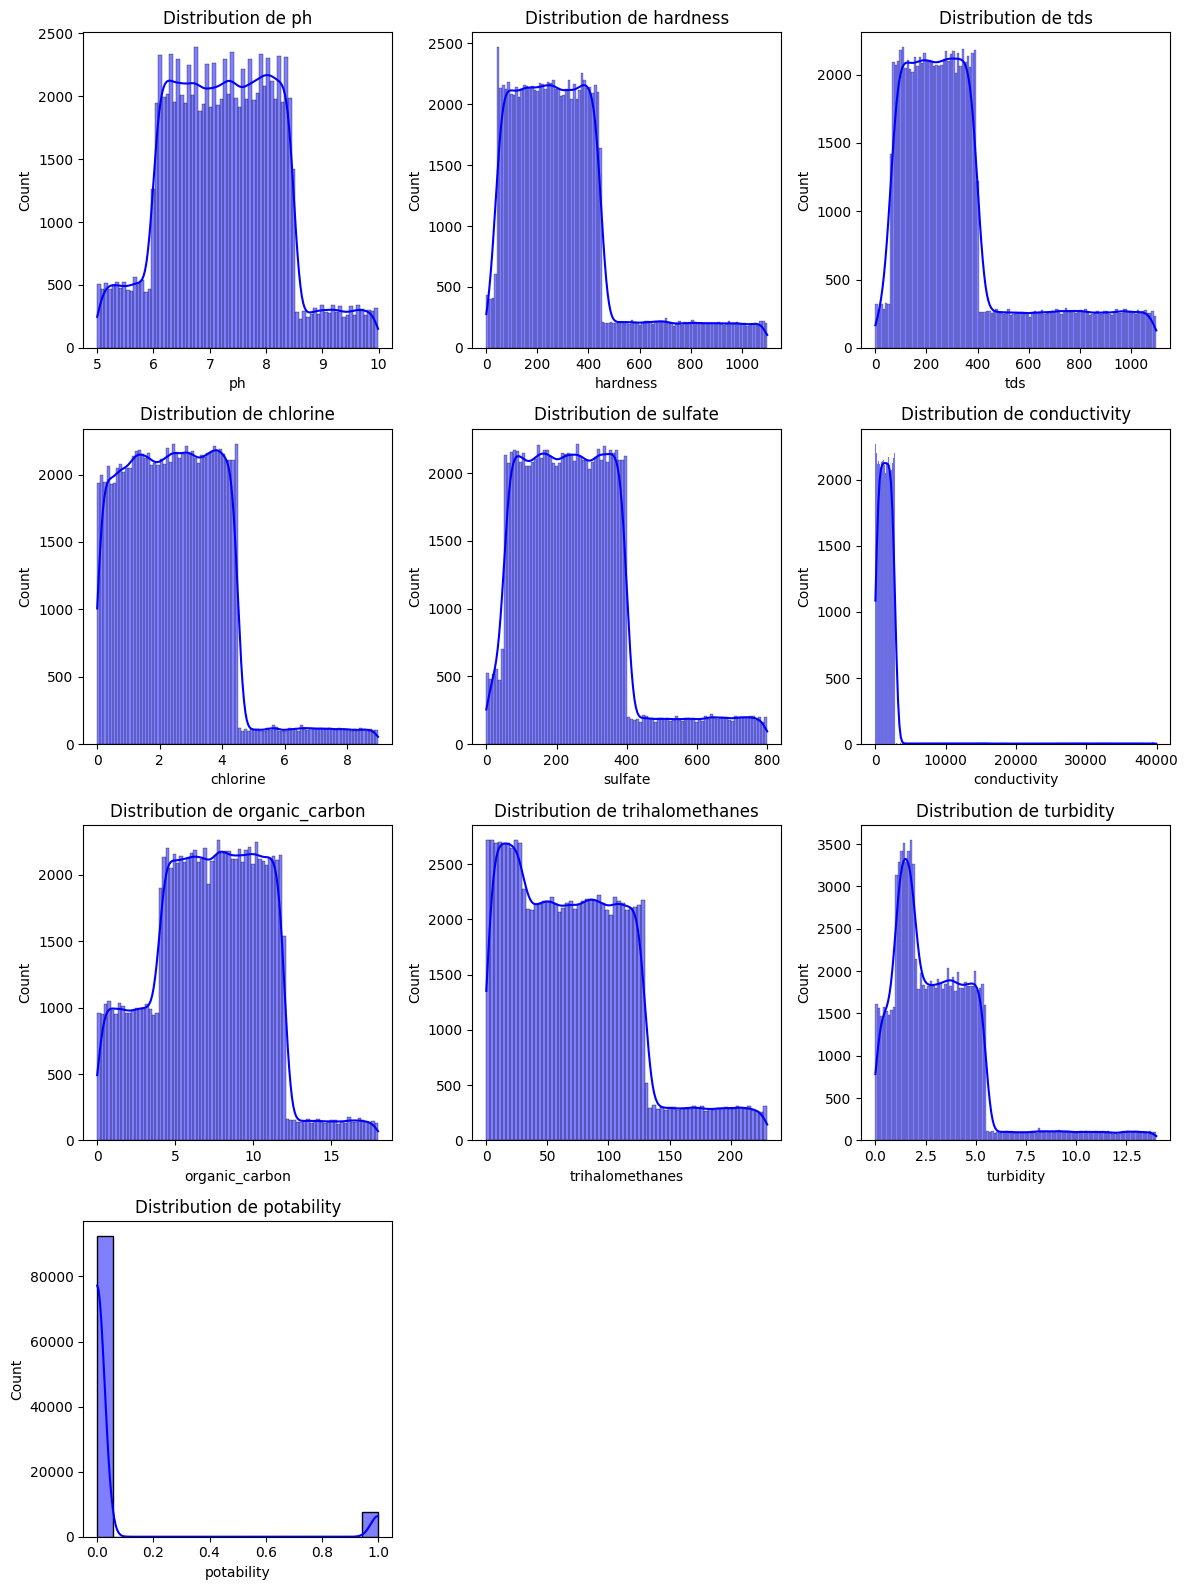

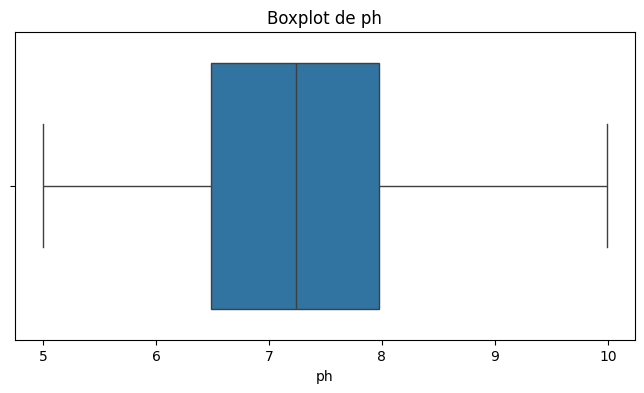

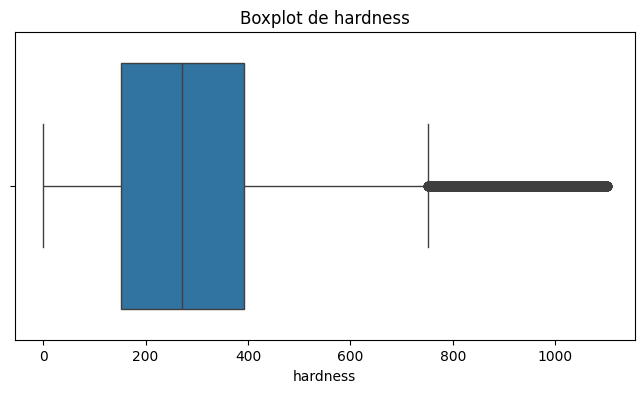

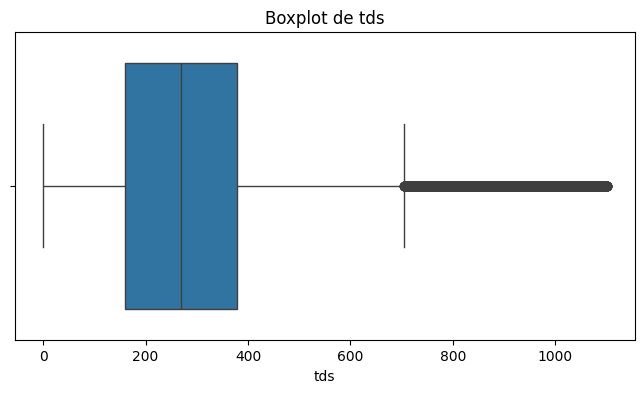

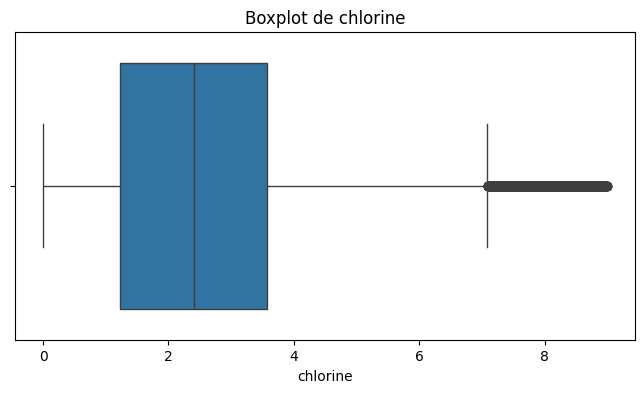

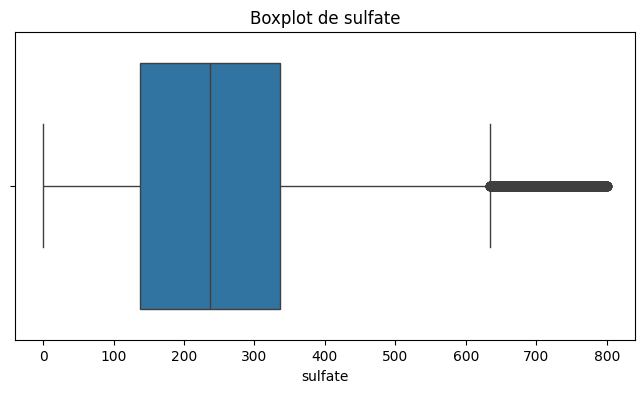

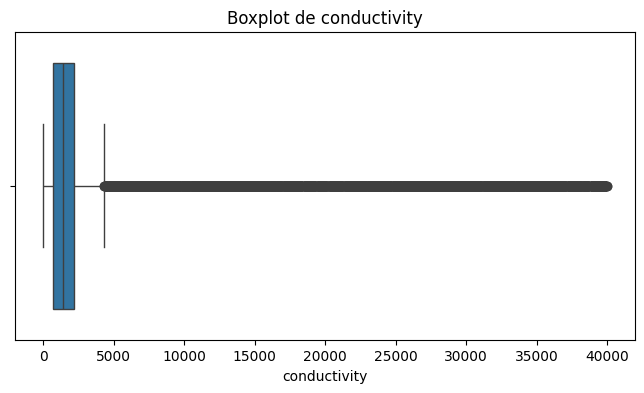

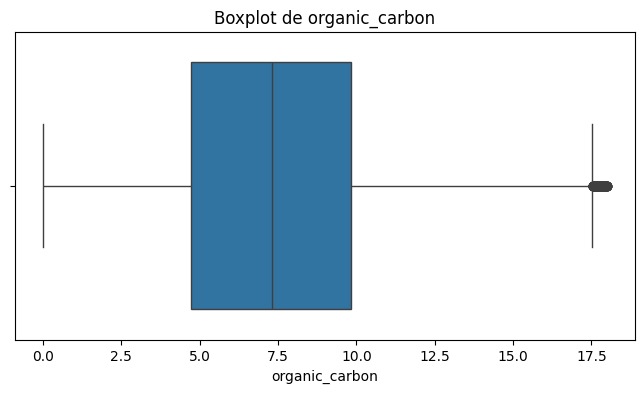

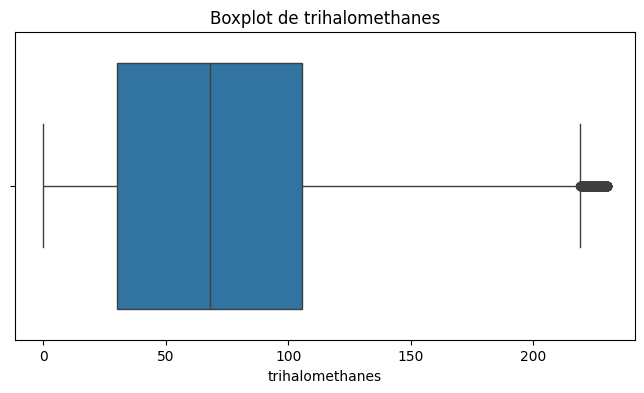

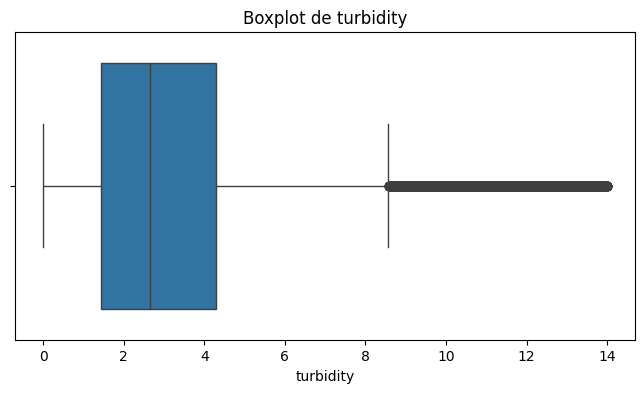

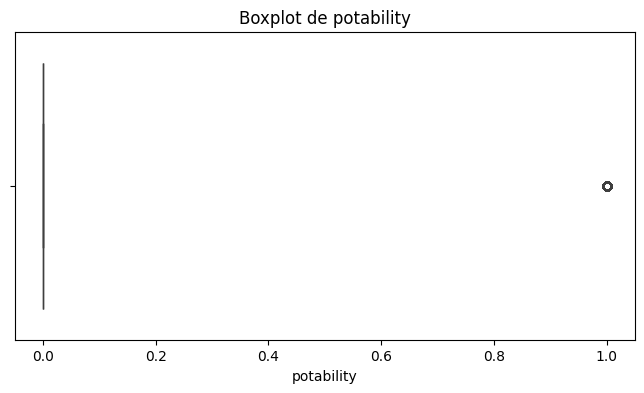

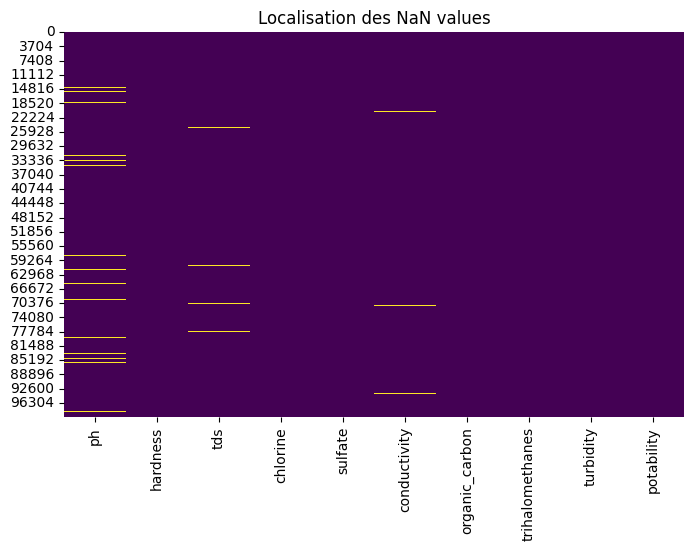

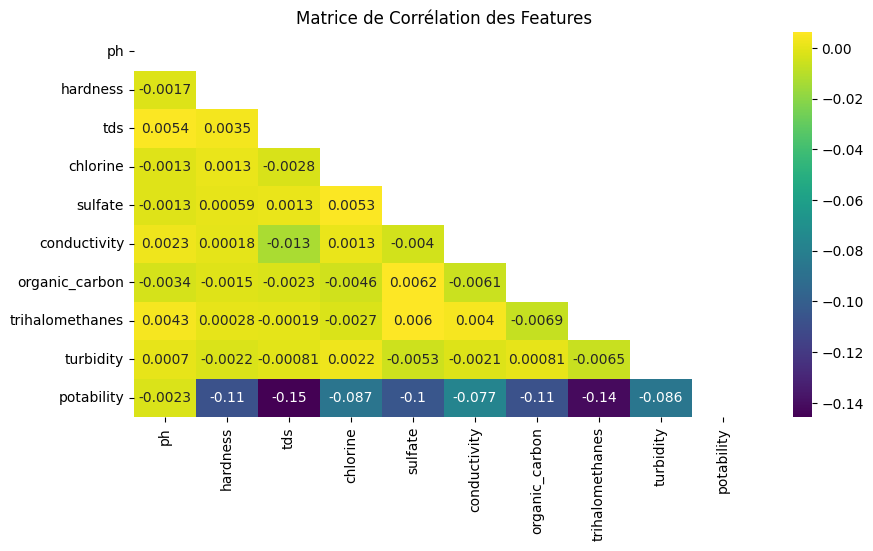

Comparaison des Modèles :
                      Accuracy       AUC  F1 Score
Logistic Regression  0.923185  0.884608  0.187858
Decision Tree        0.999512  0.997403  0.996731
Random Forest        0.999512  0.999999  0.996728
K-Nearest Neighbors  0.939437  0.921451  0.558452

Le meilleur modèle est : Random Forest


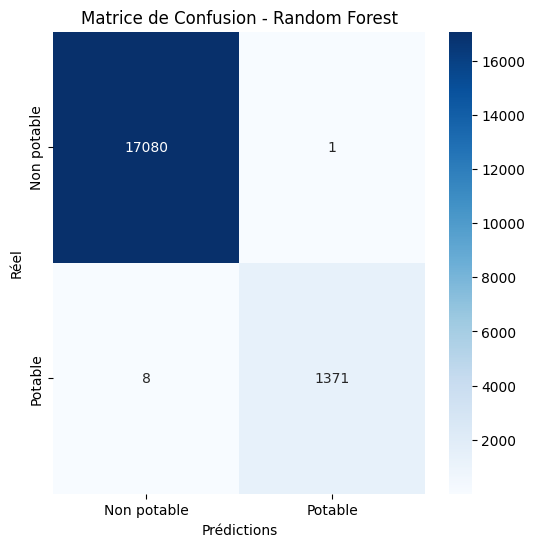


Classification Report pour Random Forest :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17081
           1       1.00      0.99      1.00      1379

    accuracy                           1.00     18460
   macro avg       1.00      1.00      1.00     18460
weighted avg       1.00      1.00      1.00     18460



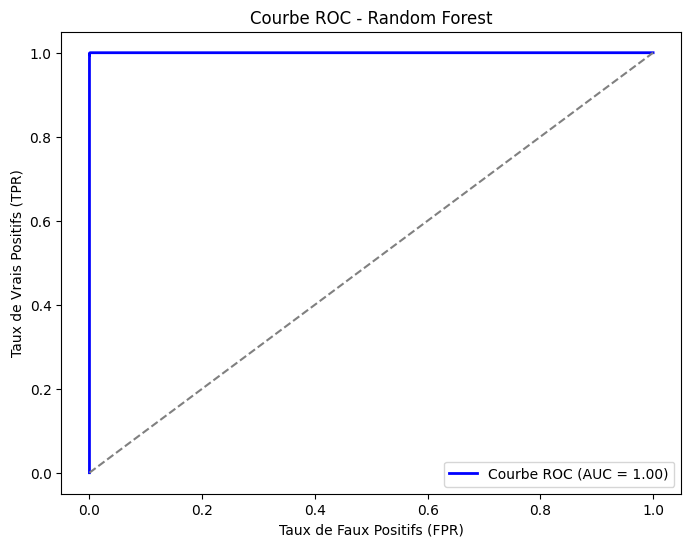

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# ############# Préprocessing #############
# Lecture du fichier
data = pd.read_csv('Data/Watera.csv')


df = pd.read_csv('Data/Watera.csv')

# Structure du dataset
print(df.head())
print(df.info())
print(df.describe())

# Sélectionner les colonnes numériques
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Visualisation de la distribution des variables numériques
n_cols = len(df_numeric.columns)
n_rows = (n_cols // 3) + (n_cols % 3 > 0)    #est utilisée pour calculer le nombre de lignes nécessaires pour afficher les graphiques de manière appropriée en fonction du nombre de colonnes 

plt.figure(figsize=(12, 4 * n_rows))
for i, column in enumerate(df_numeric.columns):
    plt.subplot(n_rows, 3, i + 1)
    sns.histplot(df_numeric[column], kde=True, color='blue')
    plt.title(f'Distribution de {column}')
plt.tight_layout()
plt.show()

# Détection des valeurs aberrantes (boxplots)
for column in df_numeric.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot de {column}')
    plt.show()


# Visualisation des NaN values
plt.figure(figsize=(8, 5))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation des NaN values")
plt.show()

# On retire les NaN values
data.dropna(axis="index", inplace=True)
data.reset_index(drop=True, inplace=True)

# Vérification des corrélations entre les features
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(data.corr(numeric_only=True), dtype=bool))
sns.heatmap(
    data.corr(numeric_only=True),
    annot=True, cmap="viridis", mask=mask, cbar=True
)
plt.title("Matrice de Corrélation des Features")
plt.show()

# Séparation des données
X = data.drop('potability', axis=1)  # Toutes les colonnes sauf 'potability'
y = data['potability']              # Colonne cible

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ############# Modélisation et sélection du meilleur modèle #############

# Liste des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionnaire pour stocker les résultats de performance
results = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe 1 (potable)

    # Calcul des métriques
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc_score = auc(*roc_curve(y_test, y_probs)[:2])  # AUC de la courbe ROC
    f1 = metrics.f1_score(y_test, y_pred)
    
    # Stockage des résultats
    results[model_name] = {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'F1 Score': f1
    }

# Affichage des résultats pour comparer les modèles
results_df = pd.DataFrame(results).T
print("Comparaison des Modèles :\n", results_df)

# Sélection du meilleur modèle basé sur l'AUC (ou une autre métrique comme Accuracy ou F1 Score)
best_model_name = results_df['AUC'].idxmax()  # Choisir le modèle avec la meilleure AUC
best_model = models[best_model_name]

print(f"\nLe meilleur modèle est : {best_model_name}")

# ############# Évaluation du meilleur modèle #############

# Prédictions et évaluation du meilleur modèle
y_pred_best = best_model.predict(X_test)
y_probs_best = best_model.predict_proba(X_test)[:, 1]

# Matrice de confusion
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Non potable', 'Potable'], yticklabels=['Non potable', 'Potable'])
plt.title(f"Matrice de Confusion - {best_model_name}")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

# Classification Report
print(f"\nClassification Report pour {best_model_name} :")
print(classification_report(y_test, y_pred_best))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # La ligne diagonale
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title(f'Courbe ROC - {best_model_name}')
plt.legend(loc='lower right')
plt.show()
